In [1]:
import numpy as np
import pandas as pd

def g(x1, x2):    
    return(3*(1-x1)**2 * np.exp(-(x1**2) - (x2+1)**2)
           - 10*(x1/5 - x1**3 - x2**5) * np.exp(-x1**2 - x2**2)
           - 1/3 * np.exp(-(x1+1)**2 - x2**2))
    
def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = g(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_g/virtual_samples_ExpSineSquared.xlsx")

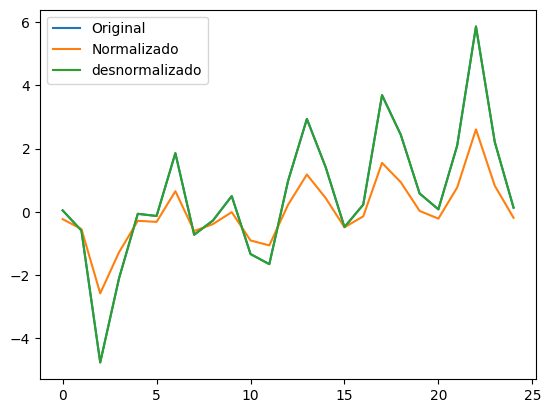

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

2025-07-21 22:18:04.272172: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:18:04.276899: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 22:18:04.297423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753136284.430156 1076007 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753136284.471663 1076007 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753136284.503439 1076007 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36], [48], [60]],
            regularizers=[0.02, 0.2],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  18
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_4,0.696017,0.510959,0.523822,0.578339,1.265554,3.270220,1.703263,1.720353,1.419761,1.124968,0.586066,1.142686,33.528980,70.493564
model_1_3_3,0.693141,0.508634,0.521662,0.573714,1.277528,3.285765,1.710987,1.739224,1.426224,1.130278,0.582149,1.148079,33.510146,70.474729
model_1_3_2,0.690211,0.506265,0.519445,0.569007,1.289726,3.301605,1.718916,1.758427,1.432809,1.135661,0.578160,1.153546,33.491141,70.455724
model_1_3_1,0.687234,0.503855,0.517179,0.564222,1.302118,3.317722,1.727022,1.777949,1.439363,1.141104,0.574107,1.159075,33.472015,70.436599
model_1_3_0,0.684210,0.501403,0.514870,0.559374,1.314710,3.334123,1.735283,1.797730,1.445927,1.146608,0.569988,1.164666,33.452768,70.417352


DataFrame salvo em ./content/results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.722964,0.531324,0.546505,0.721722,1.153369,3.134038,1.622124,0.917197,1.348772,1.073950,0.622759,1.090864,33.714625,70.679209
model_1_4_8,0.720458,0.529437,0.544494,0.720873,1.163801,3.146656,1.629318,0.919995,1.356003,1.078796,0.619347,1.095786,33.696618,70.661202
model_1_4_7,0.718127,0.527661,0.542815,0.720072,1.173507,3.158534,1.635323,0.922636,1.360078,1.083285,0.616172,1.100346,33.680006,70.644590
model_1_4_6,0.715530,0.525704,0.540692,0.719181,1.184318,3.171616,1.642917,0.925573,1.367414,1.088264,0.612636,1.105403,33.661666,70.626250
model_1_4_5,0.712881,0.523711,0.538514,0.718267,1.195345,3.184949,1.650709,0.928587,1.374857,1.093319,0.609030,1.110537,33.643129,70.607713
model_1_4_4,0.710182,0.521680,0.536275,0.717329,1.206583,3.198530,1.658717,0.931675,1.382372,1.098446,0.605354,1.115745,33.624414,70.588998
model_1_4_3,0.707449,0.519618,0.533964,0.716377,1.217960,3.212317,1.666984,0.934814,1.389741,1.103612,0.601633,1.120993,33.605645,70.570229
model_1_4_2,0.704718,0.517549,0.531655,0.715421,1.229329,3.226154,1.675244,0.937967,1.396400,1.108751,0.597914,1.126213,33.587063,70.551647
model_1_4_1,0.701863,0.515395,0.529166,0.714420,1.241217,3.240556,1.684146,0.941266,1.404217,1.114099,0.594026,1.131645,33.567816,70.532399
model_1_4_0,0.698989,0.513214,0.526590,0.713419,1.253181,3.255137,1.693361,0.944563,1.411615,1.119456,0.590113,1.137086,33.548629,70.513213


DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.756726,0.558968,0.562040,0.507119,1.012806,2.949181,1.566559,0.547980,1.293246,1.006383,0.668734,1.022232,33.974550,70.939133
model_1_5_8,0.754902,0.557334,0.561465,0.507869,1.020401,2.960108,1.568614,0.547146,1.293680,1.010149,0.666250,1.026058,33.959609,70.924192
model_1_5_7,0.750967,0.553874,0.559994,0.509199,1.036784,2.983246,1.573874,0.545668,1.298004,1.018226,0.660891,1.034262,33.927752,70.892336
model_1_5_6,0.748939,0.552113,0.559226,0.509822,1.045229,2.995021,1.576622,0.544975,1.300090,1.022364,0.658129,1.038466,33.911528,70.876112
model_1_5_5,0.742598,0.546654,0.556784,0.511560,1.071627,3.031529,1.585358,0.543043,1.306175,1.035194,0.649495,1.051497,33.861644,70.826228
model_1_5_4,0.738110,0.542836,0.554965,0.512630,1.090312,3.057061,1.591863,0.541853,1.311003,1.044180,0.643384,1.060625,33.827072,70.791656
model_1_5_3,0.735792,0.540881,0.554010,0.513149,1.099960,3.070132,1.595281,0.541276,1.313410,1.048790,0.640228,1.065307,33.809452,70.774036
model_1_5_2,0.731010,0.536891,0.552007,0.514178,1.119871,3.096810,1.602444,0.540132,1.318115,1.058240,0.633715,1.074906,33.773572,70.738156
model_1_5_1,0.728535,0.535242,0.550312,0.514817,1.130173,3.107839,1.608508,0.539421,1.320724,1.063096,0.630346,1.079838,33.755259,70.719843
model_1_5_0,0.725832,0.533361,0.548545,0.514995,1.141429,3.120419,1.614830,0.539224,1.332332,1.068377,0.626664,1.085203,33.735438,70.700021


DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.783874,0.587189,0.572013,0.681395,0.899787,2.760471,1.530884,1.716610,1.270672,0.948571,0.705700,0.963510,34.211195,71.175779
model_1_6_8,0.781459,0.585089,0.571632,0.682416,0.909840,2.774514,1.532248,1.711106,1.275791,0.953856,0.702412,0.968878,34.188972,71.153556
model_1_6_7,0.780624,0.584356,0.571490,0.682772,0.913317,2.779411,1.532755,1.709187,1.277553,0.955676,0.701275,0.970727,34.181345,71.145929
model_1_6_6,0.778932,0.582854,0.571216,0.683525,0.920360,2.789456,1.533735,1.705131,1.279510,0.959354,0.698971,0.974463,34.165981,71.130564
model_1_6_5,0.777156,0.581276,0.570872,0.684319,0.927753,2.800008,1.534966,1.700852,1.283197,0.963199,0.696553,0.978369,34.149980,71.114563
model_1_6_4,0.776245,0.580462,0.570684,0.684739,0.931546,2.805450,1.535639,1.698593,1.285077,0.965167,0.695312,0.980367,34.141819,71.106402
model_1_6_3,0.775318,0.579632,0.570484,0.685174,0.935405,2.811004,1.536352,1.696248,1.286978,0.967163,0.694050,0.982395,34.133552,71.098135
model_1_6_2,0.768383,0.573334,0.568776,0.688841,0.964278,2.853118,1.542464,1.676488,1.300793,0.981976,0.684607,0.997442,34.072752,71.037336
model_1_6_1,0.767327,0.572362,0.568487,0.689480,0.968672,2.859616,1.543498,1.673049,1.302841,0.984211,0.683169,0.999712,34.063659,71.028242
model_1_6_0,0.753089,0.558947,0.563845,0.699658,1.027949,2.949322,1.560100,1.618209,1.329694,1.013878,0.663781,1.029846,33.944870,70.909453


DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.796287,0.599102,0.565819,0.716958,0.848107,2.680806,1.553040,1.294409,1.190224,0.920927,0.722603,0.935431,34.329498,71.294081
model_1_7_8,0.795540,0.598401,0.566136,0.717029,0.851215,2.685496,1.551906,1.294085,1.197959,0.922613,0.721587,0.937143,34.322182,71.286765
model_1_7_7,0.793199,0.596223,0.567055,0.717198,0.860964,2.700057,1.548621,1.293310,1.221567,0.927881,0.718398,0.942495,34.299405,71.263989
model_1_7_6,0.792384,0.595472,0.567352,0.717244,0.864357,2.705080,1.547558,1.293099,1.229547,0.929708,0.717288,0.944350,34.291539,71.256122
model_1_7_5,0.791552,0.594708,0.567646,0.717287,0.867821,2.710192,1.546505,1.292903,1.237557,0.931569,0.716155,0.946240,34.283540,71.248124
model_1_7_4,0.789838,0.593137,0.568237,0.717379,0.874956,2.720693,1.544391,1.292483,1.253521,0.935391,0.713822,0.950122,34.267164,71.231748
model_1_7_3,0.788958,0.592330,0.568541,0.717439,0.878619,2.726089,1.543305,1.292210,1.261371,0.937347,0.712623,0.952109,34.258807,71.223391
model_1_7_2,0.788065,0.591508,0.568861,0.717523,0.882338,2.731587,1.542160,1.291826,1.269008,0.939328,0.711407,0.954122,34.250361,71.214945
model_1_7_1,0.787162,0.590670,0.569211,0.717650,0.886094,2.737192,1.540908,1.291243,1.276235,0.941326,0.710179,0.956151,34.241864,71.206448
model_1_7_0,0.786258,0.589815,0.569613,0.717857,0.889862,2.742908,1.539468,1.290298,1.282687,0.943325,0.708946,0.958181,34.233379,71.197962


DataFrame salvo em ./content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.824592,0.623870,0.532805,0.848485,0.730266,2.515184,1.671131,0.736077,1.097461,0.854556,0.761147,0.868014,34.628694,71.593277
model_1_8_8,0.816696,0.616806,0.545611,0.853387,0.763140,2.562418,1.625323,0.712258,1.118734,0.873579,0.750394,0.887337,34.540628,71.505212
model_1_8_7,0.816176,0.616362,0.546285,0.853670,0.765302,2.565386,1.622913,0.710884,1.119823,0.874815,0.749687,0.888593,34.534970,71.499554
model_1_8_6,0.815101,0.615449,0.547627,0.854246,0.769780,2.571495,1.618112,0.708089,1.122006,0.877371,0.748222,0.891189,34.523301,71.487885
model_1_8_5,0.814544,0.614978,0.548294,0.854537,0.772100,2.574641,1.615725,0.706671,1.123099,0.878692,0.747464,0.892530,34.517283,71.481867
model_1_8_4,0.809576,0.610840,0.553487,0.856998,0.792783,2.602313,1.597152,0.694718,1.132310,0.890384,0.740699,0.904406,34.464412,71.428995
model_1_8_3,0.808883,0.610267,0.554101,0.857321,0.795665,2.606143,1.594955,0.693147,1.134253,0.892000,0.739756,0.906048,34.457155,71.421739
model_1_8_2,0.806703,0.608451,0.555887,0.858322,0.804741,2.618288,1.588565,0.688286,1.140234,0.897074,0.736787,0.911202,34.434469,71.399053
model_1_8_1,0.805938,0.607805,0.556456,0.858667,0.807928,2.622609,1.586529,0.686611,1.142586,0.898848,0.735745,0.913004,34.426563,71.391147
model_1_8_0,0.805152,0.607135,0.557013,0.859021,0.811199,2.627090,1.584540,0.684890,1.145052,0.900666,0.734675,0.914850,34.418484,71.383067


DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.840503,0.653724,0.530336,0.900965,0.664024,2.315551,1.679962,0.486299,1.087300,0.814877,0.782813,0.827710,34.818874,71.783458
model_1_9_8,0.840288,0.653609,0.530890,0.901384,0.664919,2.316317,1.677978,0.484240,1.087210,0.815426,0.782520,0.828268,34.816179,71.780763
model_1_9_7,0.838274,0.652557,0.535361,0.904669,0.673306,2.323353,1.661986,0.468110,1.087212,0.820552,0.779777,0.833475,34.791110,71.755693
model_1_9_6,0.837363,0.652093,0.537042,0.905855,0.677098,2.326455,1.655973,0.462288,1.087679,0.822860,0.778536,0.835819,34.779878,71.744461
model_1_9_5,0.837037,0.651929,0.537601,0.906242,0.678454,2.327551,1.653974,0.460387,1.087914,0.823683,0.778093,0.836655,34.775878,71.740462
model_1_9_4,0.834395,0.640942,0.540829,0.939156,0.689455,2.401020,1.642427,0.298767,1.060134,0.830334,0.774495,0.843411,34.743709,71.708292
model_1_9_3,0.833924,0.640494,0.540710,0.938391,0.691413,2.404016,1.642854,0.302525,1.066415,0.831512,0.773855,0.844608,34.738037,71.702621
model_1_9_2,0.831790,0.636255,0.539393,0.940100,0.700298,2.432365,1.647564,0.294131,1.070936,0.836838,0.770948,0.850018,34.712498,71.677081
model_1_9_1,0.831076,0.635088,0.538947,0.940043,0.703273,2.440167,1.649160,0.294413,1.074054,0.838614,0.769975,0.851821,34.704020,71.668603
model_1_9_0,0.827724,0.630117,0.536562,0.939004,0.717229,2.473409,1.657691,0.299513,1.087042,0.846893,0.765411,0.860231,34.664722,71.629305


DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_4,0.845416,0.655168,0.531384,0.865914,0.643569,2.305894,1.676211,0.812745,1.083973,0.802228,0.789503,0.814862,34.881451,71.846034
model_1_10_2,0.844233,0.655162,0.530621,0.866987,0.648494,2.305936,1.678941,0.806242,1.078384,0.805291,0.787892,0.817974,34.866206,71.830790
model_1_10_3,0.844429,0.655152,0.530872,0.866542,0.647681,2.306001,1.678043,0.808936,1.080580,0.804786,0.788158,0.817461,34.868714,71.833298
model_1_10_5,0.846528,0.654728,0.531878,0.865327,0.638939,2.308836,1.674447,0.816301,1.100245,0.799337,0.791017,0.811925,34.895892,71.860476
model_1_10_6,0.846753,0.654581,0.531917,0.865151,0.638005,2.309822,1.674304,0.817372,1.107289,0.798752,0.791323,0.811331,34.898820,71.863403
model_1_10_7,0.846849,0.654570,0.531963,0.865088,0.637604,2.309891,1.674143,0.817752,1.107905,0.798501,0.791454,0.811077,34.900075,71.864658
model_1_10_1,0.842434,0.654464,0.530315,0.865961,0.655984,2.310602,1.680036,0.812459,1.081221,0.809928,0.785442,0.822684,34.843238,71.807821
model_1_10_8,0.847689,0.654251,0.532187,0.864310,0.634109,2.312023,1.673340,0.822465,1.126262,0.796310,0.792597,0.808851,34.911069,71.875653
model_1_10_9,0.847755,0.654225,0.532209,0.864240,0.633831,2.312197,1.673263,0.822893,1.127098,0.796135,0.792688,0.808674,34.911945,71.876528
model_1_10_0,0.840962,0.653880,0.530301,0.865617,0.662113,2.314509,1.680087,0.814545,1.085528,0.813703,0.783438,0.826518,34.824640,71.789223


DataFrame salvo em ./content/results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  21
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.848049,0.653706,0.535817,0.887817,0.632607,2.315673,1.660355,0.660635,1.093419,0.795366,0.793089,0.807892,34.915812,71.880396
model_1_11_1,0.847658,0.652504,0.543811,0.876835,0.634237,2.323704,1.631762,0.725303,1.079442,0.796390,0.792555,0.808932,34.910666,71.875249
model_1_11_2,0.847256,0.650772,0.546526,0.872639,0.635912,2.335291,1.622052,0.750016,1.072843,0.797441,0.792008,0.810000,34.905390,71.869973
model_1_11_3,0.846682,0.649820,0.549451,0.867789,0.638299,2.341657,1.611589,0.778572,1.067034,0.798936,0.791227,0.811519,34.897897,71.862481
model_1_11_4,0.846274,0.648469,0.551085,0.864840,0.639997,2.350688,1.605744,0.795940,1.068875,0.799998,0.790671,0.812597,34.892584,71.857167
model_1_11_5,0.845625,0.648140,0.553021,0.860920,0.642701,2.352886,1.598819,0.819023,1.072607,0.801686,0.789787,0.814312,34.884152,71.848736
model_1_11_6,0.844927,0.647300,0.554770,0.857074,0.645608,2.358507,1.592563,0.841672,1.076858,0.803497,0.788836,0.816152,34.875125,71.839709
model_1_11_7,0.844686,0.645961,0.555395,0.855702,0.646612,2.367458,1.590328,0.849751,1.078410,0.804122,0.788508,0.816786,34.872019,71.836602
model_1_11_8,0.843407,0.643376,0.558309,0.849079,0.651933,2.384749,1.579902,0.888756,1.081807,0.807424,0.786767,0.820140,34.855626,71.820210
model_1_11_9,0.842896,0.643145,0.559531,0.846526,0.654063,2.386293,1.575532,0.903790,1.079275,0.808742,0.786071,0.821479,34.849102,71.813685


DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_8,0.845267,0.647436,0.551373,0.804290,0.644192,2.357597,1.604714,1.183890,1.058157,0.802616,0.789299,0.815256,34.879517,71.844100
model_1_12_5,0.833003,0.647390,0.579417,0.765129,0.695251,2.357908,1.504400,1.420788,1.061765,0.833817,0.772599,0.846949,34.726965,71.691549
model_1_12_4,0.825572,0.647287,0.583486,0.740843,0.726188,2.358591,1.489846,1.567699,1.063938,0.852167,0.762480,0.865587,34.639893,71.604476
model_1_12_7,0.844674,0.647261,0.554284,0.804576,0.646660,2.358770,1.594299,1.182162,1.056440,0.804151,0.788492,0.816816,34.871871,71.836454
model_1_12_6,0.843075,0.647168,0.557943,0.799547,0.653316,2.359390,1.581212,1.212586,1.057009,0.808280,0.786315,0.821009,34.851389,71.815972
model_1_12_9,0.845312,0.647155,0.551112,0.804259,0.644002,2.359478,1.605645,1.184081,1.058334,0.802497,0.789361,0.815136,34.880107,71.844690
model_1_12_3,0.825110,0.647130,0.585251,0.740975,0.728108,2.359644,1.483532,1.566901,1.063131,0.853292,0.761852,0.866731,34.634613,71.599196
model_1_12_2,0.842398,0.646244,0.560411,0.800987,0.656133,2.365566,1.572383,1.203875,1.057260,0.810021,0.785394,0.822778,34.842782,71.807366
model_1_12_1,0.842399,0.646159,0.560410,0.801306,0.656132,2.366134,1.572388,1.201946,1.057114,0.810020,0.785394,0.822777,34.842787,71.807371
model_1_12_0,0.842872,0.642954,0.559671,0.806798,0.654163,2.387566,1.575031,1.168720,1.078027,0.808803,0.786038,0.821541,34.848798,71.813382


DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.837359,0.646428,0.548162,0.830445,0.677113,2.364336,1.616197,0.940141,1.020728,0.822869,0.778532,0.835828,34.779833,71.744417
model_1_13_8,0.837386,0.646416,0.548172,0.830750,0.677003,2.364417,1.616162,0.938446,1.020461,0.822802,0.778568,0.835760,34.780158,71.744742
model_1_13_7,0.837411,0.646407,0.548184,0.831057,0.676895,2.364481,1.616119,0.936748,1.020189,0.822736,0.778603,0.835694,34.780478,71.745061
model_1_13_6,0.837437,0.646402,0.548196,0.831364,0.676789,2.364514,1.616077,0.935043,1.019910,0.822672,0.778638,0.835628,34.780791,71.745375
model_1_13_5,0.837833,0.646184,0.548748,0.837987,0.675139,2.365967,1.614104,0.898322,1.013021,0.821668,0.779177,0.834609,34.785674,71.750257
model_1_13_4,0.837843,0.646179,0.548788,0.838308,0.675097,2.366000,1.613959,0.896541,1.012650,0.821643,0.779191,0.834583,34.785797,71.750381
model_1_13_3,0.837852,0.646177,0.548830,0.838630,0.675059,2.366018,1.613809,0.894757,1.012269,0.821620,0.779203,0.834560,34.785909,71.750493
model_1_13_1,0.837862,0.646107,0.549717,0.843881,0.675021,2.366483,1.610637,0.865643,1.005474,0.821597,0.779216,0.834536,34.786022,71.750606
model_1_13_2,0.837871,0.646106,0.549650,0.843550,0.674983,2.366493,1.610874,0.867476,1.005924,0.821574,0.779228,0.834512,34.786135,71.750719
model_1_13_0,0.837734,0.645880,0.550313,0.846542,0.675552,2.368005,1.608505,0.850887,1.001871,0.821920,0.779042,0.834864,34.784451,71.749035


DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_0,0.837540,0.646212,0.548263,0.570991,0.676361,2.365780,1.615839,1.455500,1.023430,0.822412,0.778777,0.835364,34.782055,71.746639
model_1_14_1,0.838362,0.644094,0.548660,0.570612,0.672937,2.379945,1.614417,1.456785,1.039745,0.820328,0.779897,0.833247,34.792206,71.756789
model_1_14_3,0.839118,0.643596,0.548880,0.570507,0.669790,2.383276,1.613631,1.457142,1.049093,0.818407,0.780927,0.831296,34.801581,71.766164
model_1_14_2,0.839045,0.643591,0.548865,0.570537,0.670094,2.383309,1.613685,1.457041,1.048060,0.818593,0.780827,0.831485,34.800673,71.765257
model_1_14_4,0.839995,0.641339,0.548516,0.569239,0.666138,2.398368,1.614933,1.461444,1.071307,0.816173,0.782121,0.829027,34.812516,71.777099
model_1_14_5,0.840191,0.640405,0.547915,0.568354,0.665323,2.404611,1.617083,1.464445,1.082588,0.815673,0.782388,0.828519,34.814965,71.779549
model_1_14_9,0.840422,0.640097,0.546736,0.566458,0.664362,2.406673,1.621297,1.470878,1.102644,0.815084,0.782702,0.827921,34.817856,71.782439
model_1_14_6,0.840214,0.639862,0.547830,0.568224,0.665226,2.408247,1.617387,1.464886,1.084140,0.815614,0.782420,0.828459,34.815257,71.779840
model_1_14_8,0.840388,0.639856,0.546983,0.566875,0.664504,2.408284,1.620415,1.469465,1.098624,0.815171,0.782656,0.828009,34.817430,71.782013
model_1_14_7,0.840276,0.639083,0.547571,0.567823,0.664970,2.413455,1.618312,1.466247,1.088631,0.815457,0.782503,0.828299,34.816027,71.780611


DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4], regularizer=0.02, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/s

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_8,0.839864,0.672486,0.539812,0.409673,0.666684,2.190088,1.646064,1.550625,1.242350,0.816507,0.781943,0.829367,34.810877,71.775461
model_2_0_7,0.839550,0.671348,0.540114,0.407611,0.667993,2.197697,1.644984,1.556042,1.245398,0.817309,0.781514,0.830180,34.806954,71.771538
model_2_0_6,0.838528,0.669272,0.538141,0.401494,0.672245,2.211579,1.652044,1.572109,1.269604,0.819906,0.780124,0.832818,34.794263,71.758847
model_2_0_5,0.834465,0.655798,0.569941,0.406345,0.689161,2.301677,1.538297,1.559368,1.171088,0.830157,0.774591,0.843231,34.744562,71.709145
model_2_0_4,0.824655,0.643141,0.558267,0.373908,0.730004,2.386320,1.580053,1.644572,1.377945,0.854402,0.761232,0.867858,34.629412,71.593995
model_2_0_1,0.684732,0.584609,0.350733,0.188046,1.312538,2.777719,2.322390,2.132779,2.438829,1.145660,0.570699,1.163703,33.456075,70.420659
model_2_0_3,0.765105,0.582298,0.536149,0.296628,0.977923,2.793177,1.659169,1.847564,1.752974,0.988900,0.680144,1.004474,34.044649,71.009233
model_2_0_2,0.706742,0.578355,0.408245,0.238203,1.220902,2.819543,2.116672,2.001031,2.319009,1.104944,0.600671,1.122346,33.600820,70.565404
model_2_0_0,0.549968,0.515235,0.190778,0.019481,1.873593,3.241625,2.894542,2.575552,2.744911,1.368793,0.387190,1.390350,32.744284,69.708868


DataFrame salvo em ./content/results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_9,0.843887,0.691364,0.543792,0.683883,0.649935,2.063851,1.631828,0.778079,1.465589,0.806185,0.787421,0.818882,34.861766,71.826349
model_2_1_8,0.844069,0.691246,0.544618,0.685509,0.649180,2.064640,1.628876,0.774076,1.462423,0.805717,0.787668,0.818406,34.864090,71.828674
model_2_1_7,0.844406,0.690986,0.546016,0.688588,0.647777,2.066379,1.623873,0.766497,1.456549,0.804846,0.788127,0.817521,34.868419,71.833002
model_2_1_6,0.844553,0.690838,0.546585,0.689971,0.647164,2.067365,1.621838,0.763093,1.454225,0.804465,0.788327,0.817135,34.870311,71.834894
model_2_1_5,0.844608,0.690782,0.546799,0.690499,0.646936,2.067739,1.621075,0.761794,1.453317,0.804323,0.788402,0.816991,34.871016,71.835600
model_2_1_4,0.844855,0.690498,0.547696,0.692919,0.645905,2.069639,1.617865,0.755837,1.449312,0.803682,0.788739,0.816339,34.874206,71.838789
model_2_1_3,0.845880,0.689156,0.552037,0.703980,0.641637,2.078616,1.602337,0.728613,1.428979,0.801023,0.790135,0.813638,34.887464,71.852047
model_2_1_2,0.846070,0.688861,0.553070,0.706308,0.640848,2.080589,1.598642,0.722881,1.424359,0.800530,0.790393,0.813137,34.889926,71.854510
model_2_1_1,0.846225,0.688577,0.553844,0.708313,0.640201,2.082488,1.595876,0.717946,1.420543,0.800126,0.790605,0.812727,34.891945,71.856529
model_2_1_0,0.847199,0.686079,0.555583,0.722953,0.636148,2.099191,1.589654,0.681913,1.392219,0.797589,0.791931,0.810150,34.904649,71.869233


DataFrame salvo em ./content/results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_1,0.849568,0.694272,0.595408,0.858114,0.626284,2.044405,1.447201,0.597698,1.235472,0.791381,0.795157,0.803844,34.935903,71.900487
model_2_2_2,0.849482,0.694191,0.598916,0.855116,0.626641,2.044947,1.434656,0.610330,1.218254,0.791607,0.795040,0.804074,34.934761,71.899345
model_2_2_3,0.849341,0.694074,0.601955,0.852380,0.627230,2.045727,1.423783,0.621856,1.203717,0.791979,0.794847,0.804452,34.932883,71.897467
model_2_2_4,0.849009,0.693909,0.606550,0.847977,0.628614,2.046829,1.407349,0.640404,1.180092,0.792852,0.794395,0.805338,34.928477,71.893060
model_2_2_5,0.848826,0.693808,0.608434,0.846079,0.629376,2.047506,1.400607,0.648397,1.169818,0.793332,0.794145,0.805826,34.926053,71.890637
model_2_2_6,0.848421,0.693497,0.611757,0.842570,0.631059,2.049584,1.388722,0.663179,1.151306,0.794392,0.793595,0.806903,34.920712,71.885295
model_2_2_7,0.848188,0.693252,0.613360,0.840811,0.632031,2.051228,1.382988,0.670591,1.142379,0.795004,0.793277,0.807525,34.917632,71.882216
model_2_2_0,0.845866,0.692854,0.553599,0.883752,0.641698,2.053884,1.596751,0.489699,1.424175,0.801060,0.790115,0.813676,34.887276,71.851860
model_2_2_8,0.846672,0.691818,0.621476,0.831278,0.638342,2.060814,1.353959,0.710749,1.089831,0.798963,0.791213,0.811546,34.897762,71.862346
model_2_2_9,0.846590,0.691743,0.621862,0.830822,0.638683,2.061319,1.352576,0.712668,1.086910,0.799176,0.791101,0.811762,34.896696,71.861279


DataFrame salvo em ./content/results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_1,0.845698,0.699280,0.576065,0.142533,0.642395,2.010914,1.516392,1.380727,1.163621,0.801495,0.789887,0.814118,34.885104,71.849688
model_2_3_0,0.846773,0.699124,0.581109,0.172083,0.637922,2.011959,1.498347,1.333145,1.148665,0.798700,0.791350,0.811279,34.899078,71.863662
model_2_3_2,0.843587,0.699028,0.568487,0.094968,0.651185,2.012600,1.543496,1.457318,1.187005,0.806961,0.787012,0.819669,34.857922,71.822505
model_2_3_9,0.830552,0.695654,0.528645,-0.114970,0.705455,2.035160,1.686011,1.795367,1.326078,0.839914,0.769262,0.853141,34.697825,71.662408
model_2_3_8,0.830885,0.695605,0.530056,-0.110486,0.704065,2.035493,1.680961,1.788148,1.321375,0.839086,0.769716,0.852301,34.701768,71.666352
model_2_3_7,0.831467,0.695514,0.532543,-0.102460,0.701643,2.036099,1.672068,1.775224,1.312957,0.837642,0.770508,0.850834,34.708660,71.673243
model_2_3_6,0.831650,0.695486,0.533330,-0.099881,0.700880,2.036284,1.669252,1.771070,1.310232,0.837186,0.770758,0.850371,34.710836,71.675420
model_2_3_5,0.832526,0.695410,0.537044,-0.087243,0.697235,2.036794,1.655966,1.750720,1.297544,0.835006,0.771950,0.848157,34.721265,71.685849
model_2_3_4,0.832985,0.695305,0.539095,-0.080274,0.695325,2.037500,1.648632,1.739499,1.290114,0.833862,0.772575,0.846994,34.726751,71.691334
model_2_3_3,0.837733,0.695095,0.558607,0.000281,0.675555,2.038898,1.578836,1.609787,1.219675,0.821922,0.779041,0.834866,34.784442,71.749025


DataFrame salvo em ./content/results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  29
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_0,0.847386,0.673283,0.573243,0.768714,0.635368,2.184755,1.526485,1.062152,1.066661,0.797100,0.792186,0.809653,34.907103,71.871686
model_2_4_1,0.847322,0.673028,0.573512,0.768311,0.635636,2.186467,1.525523,1.064002,1.063472,0.797268,0.792098,0.809824,34.906258,71.870841
model_2_4_2,0.846373,0.671073,0.576750,0.762204,0.639588,2.199533,1.513939,1.092050,1.040865,0.799742,0.790805,0.812338,34.893863,71.858446
model_2_4_3,0.844356,0.667477,0.583705,0.751370,0.647982,2.223581,1.489063,1.141803,1.012488,0.804973,0.788060,0.817651,34.867784,71.832367
model_2_4_4,0.842821,0.665863,0.582122,0.740937,0.654373,2.234373,1.494726,1.189717,1.015732,0.808933,0.785969,0.821673,34.848155,71.812739
model_2_4_6,0.841602,0.662468,0.593518,0.733304,0.659447,2.257076,1.453963,1.224769,0.993322,0.812064,0.784310,0.824853,34.832707,71.797290
model_2_4_5,0.841447,0.662217,0.591960,0.733889,0.660096,2.258755,1.459537,1.222085,0.993538,0.812463,0.784098,0.825258,34.830741,71.795325
model_2_4_7,0.841807,0.662055,0.595513,0.731761,0.658598,2.259839,1.446826,1.231856,0.989860,0.811540,0.784588,0.824321,34.835285,71.799868
model_2_4_9,0.842357,0.661607,0.600463,0.729040,0.656304,2.262833,1.429121,1.244354,0.983790,0.810126,0.785338,0.822885,34.842261,71.806845
model_2_4_8,0.841991,0.661310,0.599736,0.729731,0.657829,2.264822,1.431720,1.241179,0.984951,0.811066,0.784839,0.823840,34.837622,71.802205


DataFrame salvo em ./content/results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_9,0.845033,0.677705,0.612745,0.829954,0.645166,2.155187,1.385190,0.705344,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_5_8,0.845032,0.677694,0.612764,0.829950,0.645171,2.155259,1.385119,0.705363,0.934535,0.803225,0.788979,0.815875,34.876481,71.841065
model_2_5_6,0.845063,0.677611,0.612684,0.830125,0.645042,2.155819,1.385407,0.704638,0.934257,0.803145,0.789021,0.815794,34.876880,71.841464
model_2_5_7,0.845032,0.677585,0.612911,0.829960,0.645169,2.155988,1.384595,0.705321,0.934004,0.803224,0.788980,0.815874,34.876485,71.841069
model_2_5_5,0.845010,0.676746,0.614028,0.829944,0.645261,2.161604,1.380600,0.705389,0.930351,0.803281,0.788950,0.815932,34.876201,71.840785
model_2_5_4,0.845062,0.676270,0.614133,0.830268,0.645046,2.164786,1.380224,0.704042,0.929492,0.803147,0.789020,0.815796,34.876868,71.841452
model_2_5_3,0.845070,0.676207,0.614112,0.830327,0.645009,2.165205,1.380299,0.703797,0.929414,0.803125,0.789032,0.815773,34.876981,71.841565
model_2_5_2,0.845195,0.674540,0.614098,0.831525,0.644491,2.176351,1.380348,0.698831,0.926743,0.802802,0.789202,0.815445,34.878589,71.843173
model_2_5_1,0.845161,0.672108,0.613712,0.832973,0.644634,2.192616,1.381728,0.692825,0.924995,0.802891,0.789155,0.815536,34.878146,71.842729
model_2_5_0,0.843149,0.663420,0.602228,0.839236,0.653009,2.250709,1.422808,0.666845,0.966434,0.808090,0.786416,0.820816,34.852329,71.816912


DataFrame salvo em ./content/results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_0,0.845033,0.677705,0.612745,0.737446,0.645166,2.155187,1.38519,1.193365,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_6_1,0.845033,0.677705,0.612745,0.737446,0.645166,2.155187,1.38519,1.193365,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_6_2,0.845033,0.677705,0.612745,0.737446,0.645166,2.155187,1.38519,1.193365,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_6_3,0.845033,0.677705,0.612745,0.737446,0.645166,2.155187,1.38519,1.193365,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_6_4,0.845033,0.677705,0.612745,0.737446,0.645166,2.155187,1.38519,1.193365,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_6_5,0.845033,0.677705,0.612745,0.737446,0.645166,2.155187,1.38519,1.193365,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_6_6,0.845033,0.677705,0.612745,0.737446,0.645166,2.155187,1.38519,1.193365,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_6_7,0.845033,0.677705,0.612745,0.737446,0.645166,2.155187,1.38519,1.193365,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_6_8,0.845033,0.677705,0.612745,0.737446,0.645166,2.155187,1.38519,1.193365,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_6_9,0.845033,0.677705,0.612745,0.737446,0.645166,2.155187,1.38519,1.193365,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079


DataFrame salvo em ./content/results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_0,0.845033,0.677705,0.612745,0.728352,0.645166,2.155187,1.38519,0.681998,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_7_1,0.845033,0.677705,0.612745,0.728352,0.645166,2.155187,1.38519,0.681998,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_7_2,0.845033,0.677705,0.612745,0.728352,0.645166,2.155187,1.38519,0.681998,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_7_3,0.845033,0.677705,0.612745,0.728352,0.645166,2.155187,1.38519,0.681998,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_7_4,0.845033,0.677705,0.612745,0.728352,0.645166,2.155187,1.38519,0.681998,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_7_5,0.845033,0.677705,0.612745,0.728352,0.645166,2.155187,1.38519,0.681998,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_7_6,0.845033,0.677705,0.612745,0.728352,0.645166,2.155187,1.38519,0.681998,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_7_7,0.845033,0.677705,0.612745,0.728352,0.645166,2.155187,1.38519,0.681998,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_7_8,0.845033,0.677705,0.612745,0.728352,0.645166,2.155187,1.38519,0.681998,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_7_9,0.845033,0.677705,0.612745,0.728352,0.645166,2.155187,1.38519,0.681998,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079


DataFrame salvo em ./content/results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.845033,0.677705,0.612745,0.920101,0.645166,2.155187,1.38519,0.412376,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_8_1,0.845033,0.677705,0.612745,0.920101,0.645166,2.155187,1.38519,0.412376,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_8_2,0.845033,0.677705,0.612745,0.920101,0.645166,2.155187,1.38519,0.412376,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_8_3,0.845033,0.677705,0.612745,0.920101,0.645166,2.155187,1.38519,0.412376,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_8_4,0.845033,0.677705,0.612745,0.920101,0.645166,2.155187,1.38519,0.412376,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_8_5,0.845033,0.677705,0.612745,0.920101,0.645166,2.155187,1.38519,0.412376,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_8_6,0.845033,0.677705,0.612745,0.920101,0.645166,2.155187,1.38519,0.412376,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_8_7,0.845033,0.677705,0.612745,0.920101,0.645166,2.155187,1.38519,0.412376,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_8_8,0.845033,0.677705,0.612745,0.920101,0.645166,2.155187,1.38519,0.412376,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_8_9,0.845033,0.677705,0.612745,0.920101,0.645166,2.155187,1.38519,0.412376,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079


DataFrame salvo em ./content/results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_0,0.845033,0.677705,0.612745,0.866534,0.645166,2.155187,1.38519,0.848037,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_9_1,0.845033,0.677705,0.612745,0.866534,0.645166,2.155187,1.38519,0.848037,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_9_2,0.845033,0.677705,0.612745,0.866534,0.645166,2.155187,1.38519,0.848037,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_9_3,0.845033,0.677705,0.612745,0.866534,0.645166,2.155187,1.38519,0.848037,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_9_4,0.845033,0.677705,0.612745,0.866534,0.645166,2.155187,1.38519,0.848037,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_9_5,0.845033,0.677705,0.612745,0.866534,0.645166,2.155187,1.38519,0.848037,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_9_6,0.845033,0.677705,0.612745,0.866534,0.645166,2.155187,1.38519,0.848037,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_9_7,0.845033,0.677705,0.612745,0.866534,0.645166,2.155187,1.38519,0.848037,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_9_8,0.845033,0.677705,0.612745,0.866534,0.645166,2.155187,1.38519,0.848037,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_9_9,0.845033,0.677705,0.612745,0.866534,0.645166,2.155187,1.38519,0.848037,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079


DataFrame salvo em ./content/results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_0,0.845033,0.677705,0.612745,0.586249,0.645166,2.155187,1.38519,0.76187,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_10_1,0.845033,0.677705,0.612745,0.586249,0.645166,2.155187,1.38519,0.76187,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_10_2,0.845033,0.677705,0.612745,0.586249,0.645166,2.155187,1.38519,0.76187,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_10_3,0.845033,0.677705,0.612745,0.586249,0.645166,2.155187,1.38519,0.76187,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_10_4,0.845033,0.677705,0.612745,0.586249,0.645166,2.155187,1.38519,0.76187,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_10_5,0.845033,0.677705,0.612745,0.586249,0.645166,2.155187,1.38519,0.76187,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_10_6,0.845033,0.677705,0.612745,0.586249,0.645166,2.155187,1.38519,0.76187,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_10_7,0.845033,0.677705,0.612745,0.586249,0.645166,2.155187,1.38519,0.76187,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_10_8,0.845033,0.677705,0.612745,0.586249,0.645166,2.155187,1.38519,0.76187,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_10_9,0.845033,0.677705,0.612745,0.586249,0.645166,2.155187,1.38519,0.76187,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079


DataFrame salvo em ./content/results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_0,0.845033,0.677705,0.612745,0.933495,0.645166,2.155187,1.38519,0.359765,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_11_1,0.845033,0.677705,0.612745,0.933495,0.645166,2.155187,1.38519,0.359765,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_11_2,0.845033,0.677705,0.612745,0.933495,0.645166,2.155187,1.38519,0.359765,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_11_3,0.845033,0.677705,0.612745,0.933495,0.645166,2.155187,1.38519,0.359765,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_11_4,0.845033,0.677705,0.612745,0.933495,0.645166,2.155187,1.38519,0.359765,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_11_5,0.845033,0.677705,0.612745,0.933495,0.645166,2.155187,1.38519,0.359765,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_11_6,0.845033,0.677705,0.612745,0.933495,0.645166,2.155187,1.38519,0.359765,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_11_7,0.845033,0.677705,0.612745,0.933495,0.645166,2.155187,1.38519,0.359765,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_11_8,0.845033,0.677705,0.612745,0.933495,0.645166,2.155187,1.38519,0.359765,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_11_9,0.845033,0.677705,0.612745,0.933495,0.645166,2.155187,1.38519,0.359765,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079


DataFrame salvo em ./content/results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_0,0.845033,0.677705,0.612745,0.681742,0.645166,2.155187,1.38519,0.581075,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_12_1,0.845033,0.677705,0.612745,0.681742,0.645166,2.155187,1.38519,0.581075,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_12_2,0.845033,0.677705,0.612745,0.681742,0.645166,2.155187,1.38519,0.581075,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_12_3,0.845033,0.677705,0.612745,0.681742,0.645166,2.155187,1.38519,0.581075,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_12_4,0.845033,0.677705,0.612745,0.681742,0.645166,2.155187,1.38519,0.581075,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_12_5,0.845033,0.677705,0.612745,0.681742,0.645166,2.155187,1.38519,0.581075,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_12_6,0.845033,0.677705,0.612745,0.681742,0.645166,2.155187,1.38519,0.581075,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_12_7,0.845033,0.677705,0.612745,0.681742,0.645166,2.155187,1.38519,0.581075,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_12_8,0.845033,0.677705,0.612745,0.681742,0.645166,2.155187,1.38519,0.581075,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_12_9,0.845033,0.677705,0.612745,0.681742,0.645166,2.155187,1.38519,0.581075,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079


DataFrame salvo em ./content/results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_0,0.845033,0.677705,0.612745,0.886741,0.645166,2.155187,1.38519,0.381099,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_13_1,0.845033,0.677705,0.612745,0.886741,0.645166,2.155187,1.38519,0.381099,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_13_2,0.845033,0.677705,0.612745,0.886741,0.645166,2.155187,1.38519,0.381099,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_13_3,0.845033,0.677705,0.612745,0.886741,0.645166,2.155187,1.38519,0.381099,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_13_4,0.845033,0.677705,0.612745,0.886741,0.645166,2.155187,1.38519,0.381099,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_13_5,0.845033,0.677705,0.612745,0.886741,0.645166,2.155187,1.38519,0.381099,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_13_6,0.845033,0.677705,0.612745,0.886741,0.645166,2.155187,1.38519,0.381099,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_13_7,0.845033,0.677705,0.612745,0.886741,0.645166,2.155187,1.38519,0.381099,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_13_8,0.845033,0.677705,0.612745,0.886741,0.645166,2.155187,1.38519,0.381099,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_13_9,0.845033,0.677705,0.612745,0.886741,0.645166,2.155187,1.38519,0.381099,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079


DataFrame salvo em ./content/results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_0,0.845033,0.677705,0.612745,0.909905,0.645166,2.155187,1.38519,0.621138,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_14_1,0.845033,0.677705,0.612745,0.909905,0.645166,2.155187,1.38519,0.621138,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_14_2,0.845033,0.677705,0.612745,0.909905,0.645166,2.155187,1.38519,0.621138,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_14_3,0.845033,0.677705,0.612745,0.909905,0.645166,2.155187,1.38519,0.621138,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_14_4,0.845033,0.677705,0.612745,0.909905,0.645166,2.155187,1.38519,0.621138,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_14_5,0.845033,0.677705,0.612745,0.909905,0.645166,2.155187,1.38519,0.621138,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_14_6,0.845033,0.677705,0.612745,0.909905,0.645166,2.155187,1.38519,0.621138,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_14_7,0.845033,0.677705,0.612745,0.909905,0.645166,2.155187,1.38519,0.621138,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_14_8,0.845033,0.677705,0.612745,0.909905,0.645166,2.155187,1.38519,0.621138,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079
model_2_14_9,0.845033,0.677705,0.612745,0.909905,0.645166,2.155187,1.38519,0.621138,0.934595,0.803222,0.788981,0.815872,34.876495,71.841079


DataFrame salvo em ./content/results/metrics_2_14
Testando combinacao3: Hidden Size=[4], regularizer=0.2, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_2_2,0.702831,0.507521,0.579449,0.724266,1.237187,3.293212,1.504287,1.975527,1.556161,1.112289,0.595344,1.129807,33.574320,70.538903
model_3_2_1,0.698962,0.505019,0.577245,0.720994,1.253296,3.309941,1.512169,1.998971,1.569691,1.119507,0.590075,1.137138,33.548447,70.513030
model_3_2_0,0.694931,0.502426,0.574912,0.717596,1.270074,3.327276,1.520514,2.023317,1.583604,1.126976,0.584588,1.144724,33.521850,70.486433


DataFrame salvo em ./content/results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_9,0.743357,0.531867,0.604203,0.761576,1.068465,3.130405,1.415742,1.039722,1.358459,1.033666,0.650529,1.049945,33.867553,70.832137
model_3_3_6,0.721880,0.520597,0.585634,0.744670,1.157882,3.205771,1.482162,1.113443,1.476206,1.076049,0.621283,1.092996,33.706815,70.671398
model_3_3_8,0.726662,0.520272,0.592352,0.745489,1.137971,3.207943,1.458134,1.109873,1.403462,1.066757,0.627796,1.083557,33.741507,70.706091
model_3_3_5,0.720789,0.520100,0.585571,0.745489,1.162423,3.209094,1.482389,1.109870,1.486485,1.078157,0.619798,1.095137,33.698987,70.663571
model_3_3_7,0.721772,0.520014,0.585270,0.742574,1.158330,3.209671,1.483465,1.122585,1.466347,1.076257,0.621136,1.093207,33.706041,70.670625
model_3_3_4,0.718966,0.518960,0.585216,0.745443,1.170012,3.216717,1.483659,1.110074,1.497138,1.081671,0.617316,1.098706,33.685972,70.650556
model_3_3_3,0.716558,0.517321,0.584564,0.744623,1.180039,3.227680,1.485991,1.113649,1.508145,1.086296,0.614036,1.103404,33.668905,70.633488
model_3_3_2,0.713674,0.515286,0.583635,0.743148,1.192046,3.241283,1.489313,1.120079,1.519484,1.091808,0.610109,1.109003,33.648658,70.613242
model_3_3_1,0.710332,0.512899,0.582504,0.741168,1.205957,3.257246,1.493361,1.128717,1.531397,1.098161,0.605559,1.115456,33.625452,70.590036
model_3_3_0,0.706707,0.510301,0.581100,0.738693,1.221050,3.274617,1.498381,1.139507,1.543622,1.105011,0.600622,1.122414,33.600577,70.565161


DataFrame salvo em ./content/results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_9,0.839679,0.614432,0.684098,0.818426,0.667455,2.578293,1.129962,0.914398,1.309345,0.816979,0.781691,0.829846,34.808567,71.773150
model_3_4_8,0.834099,0.609268,0.679958,0.814027,0.690688,2.612826,1.144770,0.936548,1.313774,0.831076,0.774092,0.844165,34.740135,71.704719
model_3_4_7,0.826013,0.601901,0.674276,0.807224,0.724349,2.662089,1.165095,0.970808,1.320284,0.851087,0.763082,0.864491,34.644963,71.609547
model_3_4_6,0.816628,0.593470,0.667482,0.799445,0.763420,2.718465,1.189399,1.009985,1.326973,0.873739,0.750302,0.887500,34.539893,71.504477
model_3_4_5,0.805614,0.583781,0.659389,0.790176,0.809276,2.783258,1.218344,1.056661,1.334410,0.899598,0.735304,0.913765,34.423231,71.387814
model_3_4_4,0.799255,0.578776,0.652676,0.785874,0.835750,2.816727,1.242356,1.078325,1.342429,0.914194,0.726645,0.928591,34.358851,71.323435
model_3_4_3,0.784166,0.565739,0.641922,0.773156,0.898571,2.903902,1.280824,1.142373,1.354905,0.947930,0.706098,0.962859,34.213900,71.178484
model_3_4_2,0.782117,0.564012,0.640339,0.771510,0.907101,2.915454,1.286487,1.150662,1.357569,0.952419,0.703308,0.967418,34.195002,71.159586
model_3_4_1,0.774110,0.554079,0.628157,0.779128,0.940436,2.981877,1.330061,1.112296,1.317839,0.969761,0.692405,0.985033,34.122824,71.087408
model_3_4_0,0.763643,0.546394,0.617002,0.772640,0.984013,3.033267,1.369962,1.144970,1.314276,0.991974,0.678152,1.007597,34.032233,70.996816


DataFrame salvo em ./content/results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_9,0.865845,0.634897,0.696592,0.907183,0.558519,2.441443,1.085274,0.353408,1.152723,0.747342,0.817321,0.759111,35.164932,72.129515
model_3_5_8,0.857025,0.626474,0.693505,0.904842,0.595239,2.497773,1.096315,0.362323,1.190186,0.771517,0.805311,0.783668,35.037586,72.002169
model_3_5_7,0.856344,0.625989,0.693063,0.905136,0.598076,2.501013,1.097895,0.361204,1.196762,0.773354,0.804383,0.785533,35.028074,71.992658
model_3_5_6,0.854994,0.624767,0.692549,0.904807,0.603697,2.509182,1.099735,0.362454,1.202799,0.776979,0.802544,0.789216,35.009366,71.973949
model_3_5_5,0.853696,0.623618,0.692025,0.904509,0.609097,2.516870,1.101610,0.363590,1.208902,0.780447,0.800778,0.792738,34.991554,71.956138
model_3_5_3,0.845086,0.618465,0.686898,0.904915,0.644945,2.551327,1.119949,0.362042,1.276385,0.803084,0.789053,0.815732,34.877182,71.841765
model_3_5_4,0.845587,0.617652,0.687853,0.903258,0.642859,2.556763,1.116533,0.368353,1.259383,0.801785,0.789736,0.814412,34.883661,71.848245
model_3_5_2,0.843770,0.617634,0.686237,0.904687,0.650425,2.556881,1.122311,0.362911,1.284600,0.806489,0.787261,0.819191,34.860258,71.824842
model_3_5_1,0.842705,0.616942,0.685602,0.904708,0.654856,2.561514,1.124585,0.362832,1.292907,0.809232,0.785811,0.821976,34.846681,71.811264
model_3_5_0,0.841226,0.615736,0.684874,0.904371,0.661013,2.569574,1.127189,0.364117,1.301055,0.813027,0.783798,0.825831,34.827965,71.792548


DataFrame salvo em ./content/results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_6_9,0.894376,0.662237,0.686949,0.803679,0.439740,2.258621,1.119766,0.599939,1.071769,0.663129,0.856171,0.673573,35.643143,72.607726
model_3_6_8,0.891402,0.658929,0.688799,0.801962,0.452119,2.280742,1.113150,0.605185,1.076793,0.672398,0.852122,0.682988,35.587619,72.552203
model_3_6_7,0.891029,0.658539,0.689053,0.801813,0.453674,2.283349,1.112239,0.605642,1.077755,0.673554,0.851613,0.684161,35.580751,72.545335
model_3_6_6,0.889910,0.657431,0.690182,0.802006,0.458333,2.290760,1.108200,0.605051,1.080852,0.677003,0.850090,0.687665,35.560319,72.524903
model_3_6_5,0.889503,0.656996,0.690049,0.803826,0.460025,2.293668,1.108675,0.599489,1.088138,0.678251,0.849536,0.688933,35.552950,72.517534
model_3_6_3,0.871178,0.639832,0.695541,0.794404,0.536315,2.408443,1.089031,0.628281,1.141072,0.732336,0.824583,0.743869,35.246066,72.210650
model_3_6_4,0.871670,0.638860,0.694123,0.791432,0.534269,2.414945,1.094105,0.637364,1.121527,0.730937,0.825253,0.742449,35.253710,72.218293
model_3_6_2,0.869518,0.638302,0.695722,0.793122,0.543230,2.418678,1.088386,0.632200,1.144507,0.737041,0.822322,0.748649,35.220447,72.185030
model_3_6_1,0.867756,0.636647,0.696122,0.792425,0.550563,2.429746,1.086952,0.634330,1.148376,0.741999,0.819923,0.753685,35.193628,72.158211
model_3_6_0,0.866736,0.635689,0.696250,0.791656,0.554812,2.436152,1.086496,0.636678,1.150437,0.744857,0.818534,0.756588,35.178253,72.142836


DataFrame salvo em ./content/results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_7_9,0.908112,0.675413,0.677354,0.899173,0.382550,2.170512,1.154085,0.283501,0.940242,0.618506,0.874877,0.628247,35.921792,72.886375
model_3_7_8,0.904980,0.671257,0.679536,0.901268,0.395592,2.198305,1.146282,0.277610,0.952873,0.628961,0.870611,0.638867,35.854744,72.819327
model_3_7_7,0.904179,0.670438,0.680392,0.902562,0.398926,2.203786,1.143219,0.273972,0.963038,0.631606,0.869520,0.641553,35.837956,72.802540
model_3_7_6,0.901835,0.667671,0.683375,0.903696,0.408686,2.222283,1.132550,0.270782,0.971941,0.639285,0.866328,0.649353,35.789618,72.754201
model_3_7_5,0.900679,0.666245,0.683575,0.904317,0.413498,2.231822,1.131836,0.269037,0.976681,0.643038,0.864754,0.653165,35.766207,72.730791
model_3_7_4,0.900009,0.666019,0.683946,0.906125,0.416286,2.233329,1.130508,0.263952,0.993607,0.645202,0.863842,0.655364,35.752766,72.717349
model_3_7_2,0.898290,0.665486,0.685260,0.910340,0.423443,2.236898,1.125807,0.252103,1.033704,0.650725,0.861502,0.660973,35.718675,72.683258
model_3_7_3,0.898521,0.664931,0.684953,0.908441,0.422481,2.240610,1.126903,0.257441,1.014417,0.649985,0.861816,0.660222,35.723223,72.687807
model_3_7_0,0.894608,0.662387,0.686845,0.914102,0.438771,2.257622,1.120138,0.241522,1.068973,0.662398,0.856488,0.672830,35.647554,72.612137
model_3_7_1,0.895307,0.662266,0.686675,0.911654,0.435861,2.258432,1.120746,0.248407,1.045509,0.660198,0.857440,0.670595,35.660864,72.625448


DataFrame salvo em ./content/results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_9,0.917098,0.691337,0.668782,0.863724,0.345139,2.064034,1.184747,0.449719,0.953110,0.587486,0.887113,0.596738,36.127615,73.092198
model_3_8_8,0.916993,0.691085,0.669047,0.864189,0.345577,2.065719,1.183799,0.448183,0.952545,0.587858,0.886970,0.597116,36.125082,73.089666
model_3_8_7,0.916317,0.689499,0.670523,0.867465,0.348393,2.076323,1.178521,0.437371,0.950021,0.590248,0.886049,0.599544,36.108850,73.073434
model_3_8_6,0.915618,0.687950,0.671598,0.870476,0.351303,2.086678,1.174674,0.427437,0.947031,0.592708,0.885097,0.602043,36.092211,73.056795
model_3_8_5,0.915477,0.687655,0.671852,0.870960,0.351890,2.088650,1.173766,0.425839,0.946358,0.593203,0.884905,0.602546,36.088871,73.053455
model_3_8_4,0.914289,0.685468,0.673527,0.875540,0.356834,2.103278,1.167775,0.410724,0.947099,0.597356,0.883288,0.606764,36.060969,73.025552
model_3_8_3,0.914019,0.684927,0.673276,0.876649,0.357961,2.106895,1.168674,0.407064,0.946872,0.598299,0.882919,0.607721,36.054662,73.019245
model_3_8_2,0.912902,0.682941,0.674518,0.879695,0.362609,2.120176,1.164229,0.397014,0.944070,0.602170,0.881399,0.611654,36.028859,72.993443
model_3_8_1,0.910547,0.679087,0.676143,0.886078,0.372414,2.145947,1.158417,0.375950,0.939425,0.610258,0.878192,0.619869,35.975496,72.940080
model_3_8_0,0.910060,0.678386,0.676348,0.887330,0.374443,2.150637,1.157683,0.371818,0.939191,0.611917,0.877528,0.621554,35.964632,72.929216


DataFrame salvo em ./content/results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_9,0.918596,0.693142,0.666662,0.923107,0.338904,2.051961,1.192330,0.392919,0.940835,0.582155,0.889152,0.591323,36.164075,73.128659
model_3_9_8,0.918432,0.692791,0.667022,0.923182,0.339587,2.054311,1.191044,0.392541,0.940618,0.582741,0.888929,0.591919,36.160049,73.124632
model_3_9_7,0.918343,0.692607,0.667234,0.923220,0.339959,2.055541,1.190284,0.392346,0.940489,0.583060,0.888807,0.592243,36.157858,73.122441
model_3_9_6,0.918112,0.692218,0.667715,0.923341,0.340918,2.058141,1.188566,0.391724,0.941460,0.583882,0.888493,0.593078,36.152225,73.116808
model_3_9_5,0.918015,0.692031,0.667958,0.923383,0.341324,2.059393,1.187694,0.391510,0.941345,0.584229,0.888361,0.593431,36.149846,73.114429
model_3_9_4,0.917884,0.691769,0.667988,0.923434,0.341869,2.061144,1.187587,0.391248,0.941471,0.584696,0.888182,0.593904,36.146653,73.111237
model_3_9_2,0.917641,0.691754,0.668187,0.923534,0.342882,2.061240,1.186874,0.390738,0.947458,0.585561,0.887851,0.594783,36.140738,73.105322
model_3_9_3,0.917787,0.691578,0.668187,0.923464,0.342272,2.062419,1.186874,0.391100,0.941350,0.585040,0.888051,0.594254,36.144300,73.108883
model_3_9_1,0.917205,0.691330,0.668719,0.923657,0.344696,2.064079,1.184974,0.390113,0.951325,0.587108,0.887258,0.596355,36.130185,73.094768
model_3_9_0,0.917132,0.691299,0.668800,0.923689,0.344999,2.064284,1.184683,0.389949,0.952074,0.587366,0.887159,0.596617,36.128425,73.093009


DataFrame salvo em ./content/results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_10_9,0.919938,0.694578,0.669669,0.926059,0.333318,2.042358,1.181574,0.207374,0.937185,0.577337,0.890979,0.586429,36.197317,73.161900
model_3_10_8,0.919883,0.694463,0.669670,0.926455,0.333548,2.043130,1.181570,0.206263,0.936995,0.577536,0.890904,0.586631,36.195939,73.160523
model_3_10_7,0.919842,0.694361,0.669724,0.926671,0.333717,2.043811,1.181378,0.205656,0.936765,0.577682,0.890849,0.586780,36.194923,73.159507
model_3_10_6,0.919527,0.693700,0.669848,0.928580,0.335027,2.048230,1.180935,0.200302,0.935157,0.578815,0.890420,0.587931,36.187086,73.151670
model_3_10_2,0.919242,0.693697,0.667889,0.934434,0.336215,2.048252,1.187941,0.183884,0.938981,0.579841,0.890032,0.588973,36.180008,73.144592
model_3_10_3,0.919132,0.693650,0.667865,0.932820,0.336672,2.048564,1.188027,0.188411,0.937281,0.580234,0.889882,0.589372,36.177294,73.141877
model_3_10_5,0.919485,0.693564,0.669972,0.928852,0.335202,2.049138,1.180491,0.199540,0.934927,0.578966,0.890363,0.588085,36.186043,73.150627
model_3_10_0,0.918914,0.693561,0.666470,0.937153,0.337580,2.049156,1.193016,0.176257,0.938624,0.581016,0.889585,0.590166,36.171908,73.136492
model_3_10_4,0.919437,0.693452,0.670041,0.929090,0.335403,2.049886,1.180244,0.198873,0.934633,0.579140,0.890297,0.588260,36.184847,73.149431
model_3_10_1,0.919069,0.693334,0.667816,0.935107,0.336936,2.050676,1.188204,0.181997,0.937124,0.580462,0.889796,0.589604,36.175724,73.140308


DataFrame salvo em ./content/results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  29
3/3 ━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_11_1,0.919921,0.694294,0.672254,0.924528,0.333389,2.044256,1.172327,0.362831,0.928450,0.577398,0.890956,0.586492,36.196893,73.161477
model_3_11_0,0.919911,0.694282,0.671872,0.924788,0.333430,2.044335,1.173694,0.361581,0.930055,0.577434,0.890943,0.586528,36.196645,73.161229
model_3_11_2,0.919976,0.694243,0.676466,0.922174,0.333157,2.044598,1.157262,0.374150,0.914290,0.577198,0.891032,0.586288,36.198280,73.162864
model_3_11_3,0.919255,0.692525,0.682968,0.917228,0.336162,2.056088,1.134003,0.397927,0.896947,0.579795,0.890049,0.588926,36.180322,73.144906
model_3_11_4,0.918898,0.691769,0.692357,0.911072,0.337649,2.061144,1.100422,0.427521,0.870856,0.581076,0.889563,0.590227,36.171498,73.136081
model_3_11_5,0.918848,0.691710,0.692797,0.910729,0.337855,2.061540,1.098846,0.429170,0.869712,0.581253,0.889495,0.590407,36.170275,73.134859
model_3_11_9,0.918699,0.691567,0.695826,0.908639,0.338474,2.062493,1.088014,0.439218,0.861338,0.581785,0.889293,0.590948,36.166616,73.131200
model_3_11_7,0.918729,0.691558,0.695165,0.909096,0.338350,2.062552,1.090375,0.437020,0.863149,0.581678,0.889333,0.590839,36.167350,73.131934
model_3_11_8,0.918710,0.691555,0.695515,0.908847,0.338430,2.062575,1.089126,0.438215,0.862191,0.581748,0.889307,0.590910,36.166873,73.131457
model_3_11_6,0.918763,0.691414,0.694920,0.909357,0.338210,2.063515,1.091254,0.435766,0.864097,0.581558,0.889379,0.590717,36.168179,73.132762


DataFrame salvo em ./content/results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  24
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_12_9,0.918906,0.697605,0.683106,0.865532,0.337615,2.022114,1.133513,0.416488,0.802448,0.581046,0.889574,0.590197,36.171701,73.136284
model_3_12_7,0.919101,0.695650,0.687656,0.874439,0.336802,2.035192,1.117238,0.388901,0.809978,0.580346,0.889840,0.589486,36.176523,73.141107
model_3_12_6,0.919113,0.695582,0.687754,0.874776,0.336752,2.035645,1.116886,0.387855,0.810472,0.580303,0.889856,0.589442,36.176819,73.141402
model_3_12_8,0.919050,0.695565,0.687717,0.874060,0.337016,2.035761,1.117019,0.390072,0.809047,0.580530,0.889770,0.589673,36.175252,73.139836
model_3_12_5,0.919107,0.695452,0.687936,0.875100,0.336778,2.036514,1.116236,0.386852,0.810785,0.580326,0.889847,0.589465,36.176662,73.141246
model_3_12_4,0.919197,0.695312,0.688524,0.877227,0.336401,2.037453,1.114133,0.380265,0.814089,0.580001,0.889971,0.589136,36.178901,73.143484
model_3_12_3,0.919461,0.695179,0.689056,0.880733,0.335305,2.038338,1.112227,0.369405,0.820601,0.579055,0.890329,0.588175,36.185431,73.150014
model_3_12_2,0.919278,0.694006,0.691146,0.884104,0.336064,2.046186,1.104754,0.358965,0.824836,0.579710,0.890081,0.588840,36.180909,73.145493
model_3_12_1,0.918867,0.692112,0.694599,0.892079,0.337778,2.058846,1.092402,0.334263,0.847054,0.581187,0.889520,0.590340,36.170732,73.135316
model_3_12_0,0.918866,0.691954,0.694841,0.892523,0.337779,2.059906,1.091534,0.332888,0.848789,0.581188,0.889520,0.590341,36.170727,73.135311


DataFrame salvo em ./content/results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_13_1,0.911843,0.700002,0.683856,0.787950,0.367019,2.006087,1.130830,0.687848,0.950921,0.605821,0.879956,0.615362,36.004682,72.969265
model_3_13_9,0.919062,0.697232,0.687734,0.820783,0.336965,2.024610,1.116956,0.581345,0.859482,0.580487,0.889786,0.589629,36.175550,73.140134
model_3_13_7,0.919103,0.696877,0.687051,0.824121,0.336793,2.026984,1.119400,0.570516,0.855956,0.580339,0.889843,0.589479,36.176571,73.141155
model_3_13_8,0.919062,0.695867,0.687697,0.821148,0.336964,2.033737,1.117090,0.580162,0.859035,0.580486,0.889787,0.589628,36.175558,73.140142
model_3_13_6,0.918803,0.690453,0.686376,0.825611,0.338042,2.069939,1.121814,0.565683,0.851568,0.581414,0.889434,0.590571,36.169169,73.133753
model_3_13_0,0.918440,0.690348,0.682756,0.834853,0.339555,2.070642,1.134762,0.535706,0.838502,0.582713,0.888939,0.591890,36.160241,73.124825
model_3_13_5,0.918717,0.690275,0.686300,0.825559,0.338401,2.071135,1.122087,0.565852,0.851100,0.581722,0.889317,0.590884,36.167049,73.131633
model_3_13_4,0.918593,0.689622,0.685523,0.826337,0.338917,2.075498,1.124867,0.563328,0.848637,0.582166,0.889148,0.591334,36.164002,73.128585
model_3_13_3,0.918129,0.689339,0.685272,0.824136,0.340848,2.077395,1.125763,0.570467,0.848555,0.583821,0.888516,0.593016,36.152640,73.117224
model_3_13_2,0.918372,0.689304,0.685146,0.825854,0.339836,2.077627,1.126213,0.564896,0.847936,0.582955,0.888847,0.592136,36.158582,73.123165


DataFrame salvo em ./content/results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_14_1,0.911827,0.700753,0.685070,0.891305,0.367084,2.001063,1.126488,0.435549,0.883847,0.605875,0.879935,0.615416,36.004329,72.968913
model_3_14_2,0.911879,0.700679,0.685193,0.890611,0.366870,2.001564,1.126048,0.438329,0.886070,0.605698,0.880005,0.615237,36.005493,72.970077
model_3_14_3,0.911925,0.700640,0.685239,0.889899,0.366679,2.001824,1.125882,0.441183,0.888355,0.605540,0.880068,0.615077,36.006536,72.971120
model_3_14_4,0.911970,0.700548,0.685381,0.889217,0.366489,2.002438,1.125376,0.443917,0.890474,0.605383,0.880130,0.614917,36.007576,72.972159
model_3_14_5,0.912009,0.700512,0.685410,0.888507,0.366326,2.002675,1.125271,0.446761,0.892738,0.605249,0.880183,0.614781,36.008464,72.973047
model_3_14_0,0.910401,0.698154,0.628801,0.892173,0.373021,2.018443,1.327759,0.432072,0.867394,0.610754,0.877993,0.620373,35.972241,72.936825
model_3_14_6,0.912110,0.696799,0.691793,0.885620,0.365908,2.027504,1.102437,0.458330,0.897777,0.604904,0.880320,0.614430,36.010745,72.975329
model_3_14_8,0.911799,0.696118,0.689134,0.864529,0.367202,2.032062,1.111948,0.542844,0.960498,0.605972,0.879897,0.615515,36.003686,72.968270
model_3_14_9,0.911767,0.695784,0.689582,0.864110,0.367336,2.034292,1.110346,0.544523,0.961328,0.606083,0.879853,0.615628,36.002954,72.967538
model_3_14_7,0.911937,0.694676,0.692960,0.871197,0.366627,2.041706,1.098263,0.516124,0.940009,0.605497,0.880085,0.615033,36.006823,72.971406


DataFrame salvo em ./content/results/metrics_3_14
Testando combinacao4: Hidden Size=[4], regularizer=0.2, learning_rate=0.1


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_0_8,0.868038,0.696888,0.564008,0.730326,0.549388,2.026913,1.559517,0.840221,0.888299,0.741207,0.820308,0.752881,35.197899,72.162483
model_4_0_7,0.864702,0.692099,0.555987,0.725655,0.563279,2.058935,1.588209,0.854776,0.876720,0.750519,0.815764,0.762339,35.147961,72.112544
model_4_0_4,0.803990,0.684300,0.517402,0.635925,0.816037,2.111087,1.726226,1.134346,1.629442,0.903348,0.733093,0.917574,34.406591,71.371175
model_4_0_3,0.793237,0.682871,0.505378,0.617113,0.860805,2.120642,1.769235,1.192961,1.741564,0.927796,0.718450,0.942408,34.299774,71.264358
model_4_0_5,0.858218,0.679332,0.556152,0.731480,0.590272,2.144311,1.587618,0.836627,0.995832,0.768292,0.806935,0.780392,35.054342,72.018926
model_4_0_6,0.859445,0.678602,0.556713,0.735120,0.585166,2.149192,1.585612,0.825285,0.986188,0.764961,0.808605,0.777009,35.071720,72.036304
model_4_0_2,0.750075,0.609638,0.501535,0.633921,1.040496,2.610351,1.782982,1.140590,2.442473,1.020047,0.659677,1.036112,33.920605,70.885188
model_4_0_1,0.727837,0.592059,0.481954,0.605527,1.133078,2.727904,1.853021,1.229059,2.614431,1.064461,0.629396,1.081226,33.750124,70.714708
model_4_0_0,0.650599,0.523393,0.371130,0.487316,1.454643,3.187074,2.249433,1.597367,3.129740,1.206086,0.524219,1.225080,33.250479,70.215063


DataFrame salvo em ./content/results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  27
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_1_9,0.934361,0.771788,0.714195,0.773942,0.273269,1.526052,1.022309,0.523279,1.216930,0.522752,0.910620,0.530985,36.594594,73.559178
model_4_1_8,0.934402,0.771787,0.714234,0.774574,0.273101,1.526064,1.022168,0.521818,1.212786,0.522590,0.910675,0.530821,36.595829,73.560412
model_4_1_7,0.934444,0.771776,0.714258,0.775279,0.272926,1.526138,1.022083,0.520186,1.208238,0.522423,0.910732,0.530651,36.597110,73.561694
model_4_1_6,0.934487,0.771753,0.714262,0.776065,0.272747,1.526289,1.022069,0.518366,1.203233,0.522252,0.910790,0.530477,36.598418,73.563002
model_4_1_5,0.934529,0.771716,0.714241,0.776942,0.272570,1.526536,1.022142,0.516337,1.197719,0.522082,0.910849,0.530305,36.599721,73.564304
model_4_1_4,0.934570,0.771662,0.714191,0.777917,0.272399,1.526900,1.022323,0.514078,1.191632,0.521919,0.910904,0.530138,36.600975,73.565559
model_4_1_3,0.934608,0.771585,0.714104,0.779003,0.272242,1.527410,1.022634,0.511565,1.184899,0.521769,0.910956,0.529986,36.602124,73.566708
model_4_1_2,0.934640,0.771482,0.713972,0.780208,0.272112,1.528098,1.023106,0.508775,1.177443,0.521643,0.910998,0.529858,36.603086,73.567670
model_4_1_1,0.934661,0.771347,0.713785,0.781545,0.272020,1.529004,1.023774,0.505680,1.169172,0.521556,0.911028,0.529770,36.603757,73.568341
model_4_1_0,0.876406,0.704653,0.580958,0.808707,0.514550,1.974989,1.498891,0.442806,0.873742,0.717321,0.831702,0.728618,35.328925,72.293509


DataFrame salvo em ./content/results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  18
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_2_0,0.938499,0.756209,0.695053,0.878858,0.256042,1.630228,1.090777,0.494229,1.124356,0.506006,0.916254,0.513975,36.724825,73.689409
model_4_2_1,0.938465,0.755548,0.693988,0.878101,0.256185,1.634650,1.094586,0.497318,1.122274,0.506147,0.916208,0.514118,36.723711,73.688295
model_4_2_2,0.938425,0.754941,0.692992,0.877407,0.256353,1.638707,1.098150,0.500147,1.120431,0.506313,0.916153,0.514287,36.722402,73.686986
model_4_2_3,0.938381,0.754385,0.692061,0.876773,0.256536,1.642430,1.101482,0.502736,1.118802,0.506494,0.916093,0.514471,36.720969,73.685553
model_4_2_4,0.938334,0.753874,0.691191,0.876191,0.256729,1.645847,1.104593,0.505108,1.117573,0.506684,0.916030,0.514664,36.719469,73.684053
model_4_2_5,0.938287,0.753405,0.690378,0.875659,0.256925,1.648983,1.107498,0.507280,1.118102,0.506878,0.915966,0.514861,36.717942,73.682526
model_4_2_6,0.938240,0.752974,0.689620,0.875171,0.257121,1.651864,1.110210,0.509269,1.118689,0.507071,0.915902,0.515056,36.716421,73.681004
model_4_2_7,0.938194,0.752578,0.688913,0.874724,0.257313,1.654511,1.112740,0.511092,1.119289,0.507260,0.915839,0.515249,36.714926,73.679509
model_4_2_8,0.938149,0.752214,0.688253,0.874315,0.257500,1.656945,1.115101,0.512764,1.119893,0.507444,0.915778,0.515436,36.713473,73.678057
model_4_2_9,0.938106,0.751879,0.687637,0.873939,0.257680,1.659184,1.117304,0.514298,1.120500,0.507622,0.915719,0.515616,36.712075,73.676659


DataFrame salvo em ./content/results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_3_5,0.937145,0.756364,0.671712,0.466032,0.261681,1.629194,1.174266,0.538801,1.162696,0.511547,0.914410,0.519604,36.681261,73.645844
model_4_3_4,0.937864,0.756267,0.676901,0.494221,0.258685,1.629845,1.155707,0.510357,1.140498,0.508611,0.915390,0.516621,36.704285,73.668868
model_4_3_6,0.936191,0.756219,0.665504,0.432561,0.265652,1.630164,1.196474,0.572575,1.191035,0.515414,0.913111,0.523531,36.651139,73.615723
model_4_3_3,0.938358,0.755916,0.681036,0.517701,0.256631,1.632188,1.140916,0.486664,1.131736,0.506588,0.916062,0.514566,36.720233,73.684816
model_4_3_7,0.935005,0.755853,0.658402,0.393684,0.270591,1.632611,1.221875,0.611804,1.221857,0.520183,0.911496,0.528376,36.614295,73.578879
model_4_3_2,0.938634,0.755309,0.684141,0.537221,0.255481,1.636252,1.129810,0.466968,1.124404,0.505451,0.916438,0.513411,36.729216,73.693800
model_4_3_8,0.933606,0.755302,0.650645,0.349927,0.276414,1.636298,1.249624,0.655957,1.257409,0.525751,0.909591,0.534031,36.571709,73.536293
model_4_3_9,0.932034,0.754611,0.642540,0.302422,0.282959,1.640920,1.278613,0.703891,1.292026,0.531939,0.907450,0.540317,36.524904,73.489487
model_4_3_1,0.938694,0.754439,0.686254,0.553492,0.255231,1.642068,1.122252,0.450550,1.119318,0.505204,0.916520,0.513160,36.731172,73.695755
model_4_3_0,0.938527,0.753300,0.687410,0.567089,0.255929,1.649687,1.118116,0.436830,1.118827,0.505894,0.916291,0.513861,36.725712,73.690295


DataFrame salvo em ./content/results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  58
3/3 ━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_4_3,0.937142,0.756767,0.673755,0.922150,0.261692,1.626497,1.166959,0.135548,1.195913,0.511558,0.914407,0.519615,36.681177,73.645761
model_4_4_2,0.936368,0.756505,0.668362,0.923568,0.264914,1.628253,1.186249,0.133079,1.211735,0.514698,0.913353,0.522804,36.656702,73.621286
model_4_4_1,0.935340,0.756103,0.661624,0.924868,0.269195,1.630944,1.210350,0.130815,1.231698,0.518840,0.911952,0.527012,36.624635,73.589219
model_4_4_9,0.937170,0.755513,0.698784,0.873399,0.261577,1.634886,1.077433,0.220429,1.154818,0.511446,0.914444,0.519501,36.682055,73.646638
model_4_4_8,0.937174,0.755507,0.698774,0.873458,0.261558,1.634924,1.077468,0.220328,1.154540,0.511428,0.914450,0.519482,36.682198,73.646781
model_4_4_7,0.937179,0.755501,0.698763,0.873520,0.261539,1.634963,1.077506,0.220220,1.154266,0.511408,0.914457,0.519463,36.682347,73.646931
model_4_4_0,0.933951,0.755501,0.653175,0.925934,0.274979,1.634964,1.240572,0.128960,1.254941,0.524384,0.910061,0.532643,36.582123,73.546707
model_4_4_6,0.937184,0.755495,0.698752,0.873585,0.261518,1.635003,1.077545,0.220107,1.153993,0.511388,0.914463,0.519442,36.682506,73.647090
model_4_4_5,0.937189,0.755489,0.698741,0.873654,0.261496,1.635044,1.077586,0.219986,1.153723,0.511367,0.914471,0.519420,36.682674,73.647257
model_4_4_4,0.937195,0.755483,0.698729,0.873727,0.261473,1.635087,1.077630,0.219859,1.153456,0.511344,0.914478,0.519397,36.682852,73.647435


DataFrame salvo em ./content/results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_5_0,0.936550,0.753358,0.672906,0.804404,0.264158,1.649297,1.169998,0.464105,1.224099,0.513963,0.913600,0.522057,36.662418,73.627001
model_4_5_1,0.935985,0.752718,0.668567,0.796157,0.266511,1.653574,1.185515,0.483674,1.235775,0.516247,0.912830,0.524377,36.644682,73.609266
model_4_5_2,0.935343,0.752026,0.664058,0.787549,0.269181,1.658203,1.201645,0.504097,1.249051,0.518826,0.911957,0.526997,36.624745,73.589328
model_4_5_3,0.934627,0.751282,0.659356,0.778499,0.272164,1.663177,1.218463,0.525572,1.263449,0.521693,0.910981,0.529909,36.602704,73.567288
model_4_5_4,0.933834,0.750486,0.654440,0.768913,0.275467,1.668498,1.236049,0.548318,1.278655,0.524849,0.909901,0.533115,36.578576,73.543160
model_4_5_5,0.932959,0.749637,0.649288,0.758692,0.279108,1.674178,1.254477,0.572569,1.294425,0.528306,0.908710,0.536627,36.552316,73.516900
model_4_5_6,0.931998,0.748733,0.643883,0.747735,0.283109,1.680226,1.273811,0.598568,1.310769,0.532080,0.907401,0.540460,36.523846,73.488429
model_4_5_7,0.930944,0.747771,0.638214,0.735941,0.287498,1.686654,1.294086,0.626552,1.327774,0.536188,0.905966,0.544632,36.493081,73.457665
model_4_5_8,0.929791,0.746753,0.632283,0.723222,0.292299,1.693465,1.315302,0.656732,1.345262,0.540647,0.904396,0.549161,36.459956,73.424540
model_4_5_9,0.928533,0.745678,0.626102,0.709505,0.297535,1.700655,1.337412,0.689278,1.363143,0.545467,0.902683,0.554058,36.424450,73.389033


DataFrame salvo em ./content/results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_6_9,0.937910,0.756041,0.703868,0.834885,0.258495,1.631354,1.059248,0.314583,0.981081,0.508424,0.915452,0.516431,36.705758,73.670342
model_4_6_8,0.937974,0.755856,0.701205,0.838933,0.258231,1.632589,1.068772,0.306870,0.997002,0.508164,0.915539,0.516167,36.707803,73.672386
model_4_6_7,0.937985,0.755604,0.698008,0.843385,0.258184,1.634274,1.080209,0.298387,1.015414,0.508118,0.915554,0.516120,36.708167,73.672751
model_4_6_6,0.937917,0.755263,0.694148,0.848262,0.258465,1.636557,1.094013,0.289095,1.036847,0.508395,0.915462,0.516402,36.705987,73.670571
model_4_6_5,0.937733,0.754803,0.689464,0.853578,0.259233,1.639634,1.110768,0.278967,1.061738,0.509150,0.915211,0.517168,36.700052,73.664636
model_4_6_4,0.937378,0.754184,0.683746,0.859339,0.260712,1.643776,1.131222,0.267993,1.090729,0.510599,0.914727,0.518641,36.688681,73.653265
model_4_6_3,0.936775,0.753350,0.676723,0.865534,0.263221,1.649350,1.156344,0.256189,1.124715,0.513051,0.913906,0.521131,36.669521,73.634104
model_4_6_2,0.935811,0.752225,0.668036,0.872138,0.267233,1.656872,1.187417,0.243608,1.164921,0.516946,0.912594,0.525087,36.639271,73.603854
model_4_6_1,0.934318,0.750698,0.657203,0.879098,0.273449,1.667082,1.226164,0.230347,1.215577,0.522923,0.910561,0.531159,36.593283,73.557866
model_4_6_0,0.932034,0.748604,0.643555,0.886335,0.282957,1.681089,1.274983,0.216558,1.280807,0.531937,0.907451,0.540315,36.524919,73.489503


DataFrame salvo em ./content/results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  31
3/3 ━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_7_9,0.937564,0.758812,0.706244,0.950450,0.259937,1.612823,1.050747,0.317825,1.025856,0.509841,0.914980,0.517870,36.694628,73.659212
model_4_7_8,0.937599,0.758741,0.706181,0.950591,0.259790,1.613303,1.050974,0.316923,1.025227,0.509696,0.915029,0.517723,36.695767,73.660350
model_4_7_7,0.937636,0.758666,0.706115,0.950739,0.259635,1.613804,1.051210,0.315972,1.024570,0.509543,0.915079,0.517568,36.696961,73.661544
model_4_7_6,0.937675,0.758587,0.706047,0.950896,0.259472,1.614327,1.051453,0.314966,1.023881,0.509384,0.915133,0.517406,36.698212,73.662796
model_4_7_5,0.937716,0.758506,0.705977,0.951062,0.259302,1.614870,1.051704,0.313902,1.023158,0.509217,0.915188,0.517237,36.699525,73.664108
model_4_7_4,0.937759,0.758422,0.705905,0.951237,0.259123,1.615435,1.051960,0.312775,1.022397,0.509042,0.915247,0.517058,36.700903,73.665486
model_4_7_3,0.939043,0.756097,0.704671,0.963746,0.253779,1.630982,1.056374,0.232544,0.981120,0.503765,0.916994,0.511699,36.742579,73.707163
model_4_7_2,0.938898,0.756077,0.704587,0.964806,0.254382,1.631115,1.056676,0.225740,0.977896,0.504363,0.916797,0.512306,36.737837,73.702420
model_4_7_1,0.938677,0.756064,0.704445,0.965933,0.255303,1.631203,1.057184,0.218516,0.974275,0.505275,0.916496,0.513233,36.730607,73.695190
model_4_7_0,0.938357,0.756054,0.704218,0.967124,0.256635,1.631271,1.057996,0.210872,0.974065,0.506592,0.916061,0.514570,36.720201,73.684785


DataFrame salvo em ./content/results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_8_9,0.935770,0.763374,0.712157,0.829821,0.267404,1.582322,1.029596,0.532580,1.085699,0.517111,0.912538,0.525255,36.637990,73.602574
model_4_8_8,0.936074,0.763371,0.712451,0.833093,0.266139,1.582340,1.028545,0.522338,1.078627,0.515887,0.912952,0.524012,36.647471,73.612054
model_4_8_7,0.936382,0.763337,0.712694,0.836628,0.264855,1.582566,1.027677,0.511278,1.071194,0.514641,0.913372,0.522746,36.657143,73.621727
model_4_8_6,0.936691,0.763264,0.712872,0.840442,0.263569,1.583051,1.027040,0.499340,1.063296,0.513390,0.913792,0.521476,36.666876,73.631460
model_4_8_5,0.936995,0.763145,0.712968,0.844556,0.262305,1.583852,1.026697,0.486467,1.056674,0.512157,0.914206,0.520223,36.676493,73.641077
model_4_8_4,0.937286,0.762968,0.712961,0.848985,0.261094,1.585037,1.026722,0.472604,1.052597,0.510974,0.914602,0.519021,36.685748,73.650331
model_4_8_3,0.937554,0.762721,0.712824,0.853749,0.259978,1.586687,1.027211,0.457697,1.048334,0.509881,0.914967,0.517911,36.694314,73.658898
model_4_8_2,0.937786,0.762391,0.712525,0.858861,0.259012,1.588892,1.028283,0.441698,1.043876,0.508932,0.915283,0.516947,36.701762,73.666345
model_4_8_1,0.937965,0.761962,0.712018,0.864336,0.258266,1.591760,1.030096,0.424565,1.039241,0.508199,0.915527,0.516203,36.707527,73.672111
model_4_8_0,0.938069,0.761415,0.711243,0.870183,0.257835,1.595416,1.032865,0.406266,1.035180,0.507775,0.915668,0.515772,36.710869,73.675453


DataFrame salvo em ./content/results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_9_0,0.936090,0.761064,0.695675,0.813138,0.266071,1.597766,1.088554,0.547932,1.196431,0.515821,0.912974,0.523945,36.647983,73.612566
model_4_9_1,0.935597,0.760222,0.690931,0.801138,0.268125,1.603394,1.105521,0.583119,1.239131,0.517808,0.912302,0.525963,36.632601,73.597185
model_4_9_2,0.934955,0.759387,0.686605,0.789738,0.270796,1.608980,1.120996,0.616549,1.279609,0.520381,0.911429,0.528576,36.612777,73.577360
model_4_9_3,0.934221,0.758572,0.682680,0.778982,0.273852,1.614430,1.135034,0.648089,1.315872,0.523309,0.910429,0.531550,36.590336,73.554920
model_4_9_4,0.933435,0.757786,0.679130,0.768889,0.277125,1.619689,1.147734,0.677683,1.348517,0.526426,0.909359,0.534717,36.566576,73.531160
model_4_9_5,0.932626,0.757033,0.675922,0.759461,0.280494,1.624720,1.159209,0.705331,1.378060,0.529616,0.908257,0.537957,36.542409,73.506993
model_4_9_6,0.931815,0.756318,0.673023,0.750682,0.283873,1.629506,1.169577,0.731072,1.404671,0.532797,0.907152,0.541188,36.518459,73.483042
model_4_9_7,0.931015,0.755640,0.670402,0.742531,0.287201,1.634037,1.178952,0.754972,1.429602,0.535911,0.906063,0.544351,36.495146,73.459729
model_4_9_8,0.930238,0.755001,0.668030,0.734980,0.290436,1.638312,1.187439,0.777115,1.454009,0.538921,0.905005,0.547409,36.472743,73.437327
model_4_9_9,0.929490,0.754399,0.665878,0.727997,0.293550,1.642334,1.195134,0.797592,1.476226,0.541802,0.903986,0.550335,36.451416,73.415999


DataFrame salvo em ./content/results/metrics_4_9
+++++++++++ [4_10] | 1 ++++++++++++++++++
